In [1]:
import numpy as np
import itertools
import logging
import matplotlib.pyplot as plt

# import time
import torch
import torch.optim as optim
import torch.nn.functional as F
from argparse import ArgumentParser
from torch.distributions import MultivariateNormal

from nf.TNF import *
from nf.models import NormalizingFlowModel

from tensorboardX import SummaryWriter

In [2]:
def StableVariable(m, alpha):
     V = np.pi/2 * (2*np.random.rand(m)-1)
     W = np.random.exponential(scale=1, size=m)
     y = np.sin(alpha * V) / (np.cos(V)**(1/alpha) ) * (np.cos( V*(1-alpha)) / W )**((1-alpha)/alpha)
     return y

def GeneratingData(T, dt, n_samples):
    t = np.arange(0, T, dt)
    
    Nt = len(t)
    # #multimodal initial distribution
    # mu = np.array([[2, 3]])
    # sigma = np.eye(2)
    # X0 = 1*np.random.multivariate_normal(mu[0],sigma,250)  + 0.5*np.random.multivariate_normal(-mu[0],sigma,250)
    # XX0 = 1*np.random.multivariate_normal(mu[0],sigma,250)  + 0.5*np.random.multivariate_normal(-mu[0],sigma,250)
    
    
    #single-model initial distribution
    X0 = np.random.randn(n_samples//2,2)
    XX0 = np.random.randn(n_samples//2,2)
    
    # #fixed initial value
    # X0 = np.ones([n_samples//2,2])
    # XX0 = np.ones([n_samples//2,2])   
    
    
    x0 = X0[:,0:1]
    xx0 = XX0[:,0:1]
    y0 = X0[:,1:]
    yy0 = XX0[:,1:]
    N = len(x0) + len(xx0)
    alpha = 1.5
    x = np.zeros((Nt, N))
    y = np.zeros((Nt, N))
    x[0, 0:n_samples//2] = x0.squeeze()
    x[0, n_samples//2:n_samples] = xx0.squeeze()
    y[0, 0:n_samples//2] = y0.squeeze()
    y[0, n_samples//2:n_samples] = yy0.squeeze()
    for i in range(Nt-1):
        Ut = dt**(1/alpha) * StableVariable(N, alpha)
        Vt = dt**(1/alpha) * StableVariable(N, alpha)
        UUt = dt**(1/2) * np.random.randn(N)
        VVt = dt**(1/2) * np.random.randn(N)
        # #Multimodal case
        # x[i+1, :] = x[i, :] + (8*x[i, :] - 1*x[i, :]**3)*dt + 0*x[i, :]*UUt+ 1*UUt
        # y[i+1, :] = y[i, :] + (8*y[i, :] - 1*y[i, :]**3)*dt + 0*y[i, :]*VVt + 1*VVt
        
        # #Unimodal case
        x[i+1, :] = x[i, :] + 1*(4*x[i, :] - 1*x[i, :]**3)*dt + x[i, :]*Ut
        y[i+1, :] = y[i, :] - x[i, :]*y[i, :]*dt + y[i, :]*Vt
     
        b=np.empty(0).astype(int)
        for j in range(n_samples):
            if (np.abs(x[:,j])>1e4).any() or (np.abs(y[:,j])>1e4).any():
                b = np.append(b,j)
        x1 = np.delete(x,b,axis=1)
        y1 = np.delete(y,b,axis=1)
    print('shape of x1', x1.shape)
    print('shape of y1', y1.shape)
    print('shape of t', t.shape)
    return t, x1, y1

In [3]:
# #Estimating baseline density 
def sample2density(x, u, v, du, dv):
    m, n = u.shape
    l, s =x.shape
    count = np.zeros((m,n))
    for i in range(m):
        for j in range(n):
            for k in range(l):
                if x[k,0]>=u[i,j]- du/2 and x[k,0]<u[i,j] + du/2 and x[k,1]>=v[i,j]- dv/2 and x[k,1]<v[i,j]+ dv/2:
                    count[i,j] += 1
    return count/(l*du*dv)


def plot_data(x, **kwargs):
    plt.scatter(x[:,0], x[:,1], s=1, marker="o", **kwargs)
    # #Unimodal case
    # plt.xlim((-5, 5))
    # plt.ylim((-20, 20))
    
    # #Multimodal case
    plt.xlim((-8, 8))
    plt.ylim((-8, 8))
    plt.xlabel("x")
    plt.ylabel("y")


In [4]:
argparser = ArgumentParser()
argparser.add_argument("--n", default=512, type=int)
argparser.add_argument("--flows", default=1, type=int)
argparser.add_argument("--flow", default="RealNVP", type=str)
argparser.add_argument("--iterations", default=10000, type=int)
argparser.add_argument("--use-mixture", action="store_true")
argparser.add_argument("--convolve", action="store_true")
argparser.add_argument("--actnorm", action="store_true")
args = argparser.parse_args(args=[]) 
logging.basicConfig(level=logging.DEBUG)
# logger = logging.getLogger(__name__)

flow = eval(args.flow)
flows = [flow(dim=2) for _ in range(args.flows)]
prior = MultivariateNormal(torch.zeros(2), torch.eye(2))
model = NormalizingFlowModel(prior, flows)
optimizer = optim.Adam(model.parameters(), lr=0.005)
T = 1
dt = 0.05
time, position_x, position_y = GeneratingData(T, dt, 500)

shape of x1 (20, 483)
shape of y1 (20, 483)
shape of t (20,)


/tmp/ipykernel_7909/1260369468.py:49: RuntimeWarning: overflow encountered in power
  x[i+1, :] = x[i, :] + 1*(4*x[i, :] - 1*x[i, :]**3)*dt + x[i, :]*Ut
/tmp/ipykernel_7909/1260369468.py:49: RuntimeWarning: invalid value encountered in subtract
  x[i+1, :] = x[i, :] + 1*(4*x[i, :] - 1*x[i, :]**3)*dt + x[i, :]*Ut
/tmp/ipykernel_7909/1260369468.py:50: RuntimeWarning: overflow encountered in multiply
  y[i+1, :] = y[i, :] - x[i, :]*y[i, :]*dt + y[i, :]*Vt
/tmp/ipykernel_7909/1260369468.py:50: RuntimeWarning: invalid value encountered in add
  y[i+1, :] = y[i, :] - x[i, :]*y[i, :]*dt + y[i, :]*Vt
/tmp/ipykernel_7909/1260369468.py:50: RuntimeWarning: invalid value encountered in subtract
  y[i+1, :] = y[i, :] - x[i, :]*y[i, :]*dt + y[i, :]*Vt


In [5]:
t = np.repeat(time, position_x.shape[1]).reshape(-1, 1)
P_x = np.reshape(position_x, position_x.size, order='C').reshape(-1, 1)
P_y = np.reshape(position_y, position_y.size, order='C').reshape(-1, 1)
x = torch.Tensor(np.concatenate((P_x,P_y,t),axis=1))

print('shape of x', x.shape)

# write to file
with open('data.txt', 'w') as f:
    for i in range(x.shape[0]):
        f.write(str(x[i,0].item()) + '\t' + str(x[i,1].item()) + '\t' + str(x[i,2].item()) + '\n')

shape of x torch.Size([9660, 3])


In [23]:
writer = SummaryWriter('2Duni')
Loss = np.zeros([args.iterations, 1])
for i in range(args.iterations):
    optimizer.zero_grad()
    z, prior_logprob, log_det, px = model(x)
    logprob = prior_logprob + log_det
    loss = -torch.mean(prior_logprob + log_det)
    loss.backward()
    optimizer.step()
    Loss[i] = loss.detach().numpy()
    writer.add_scalar('Loss', loss.item(), i)
writer.close()
np.save('2Dloss_Ex1.npy',Loss)

DEBUG:matplotlib.pyplot:Loaded backend module://matplotlib_inline.backend_inline version unknown.
DEBUG:matplotlib.pyplot:Loaded backend module://matplotlib_inline.backend_inline version unknown.
DEBUG:matplotlib.font_manager:findfont: Matching sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0.
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/home/prani/.local/lib/python3.10/site-packages/matplotlib/mpl-data/fonts/ttf/STIXSizTwoSymBol.ttf', name='STIXSizeTwoSym', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/home/prani/.local/lib/python3.10/site-packages/matplotlib/mpl-data/fonts/ttf/STIXGeneral.ttf', name='STIXGeneral', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/home/prani/.local/lib/python3.10/site-packages/matplotlib/mpl-da

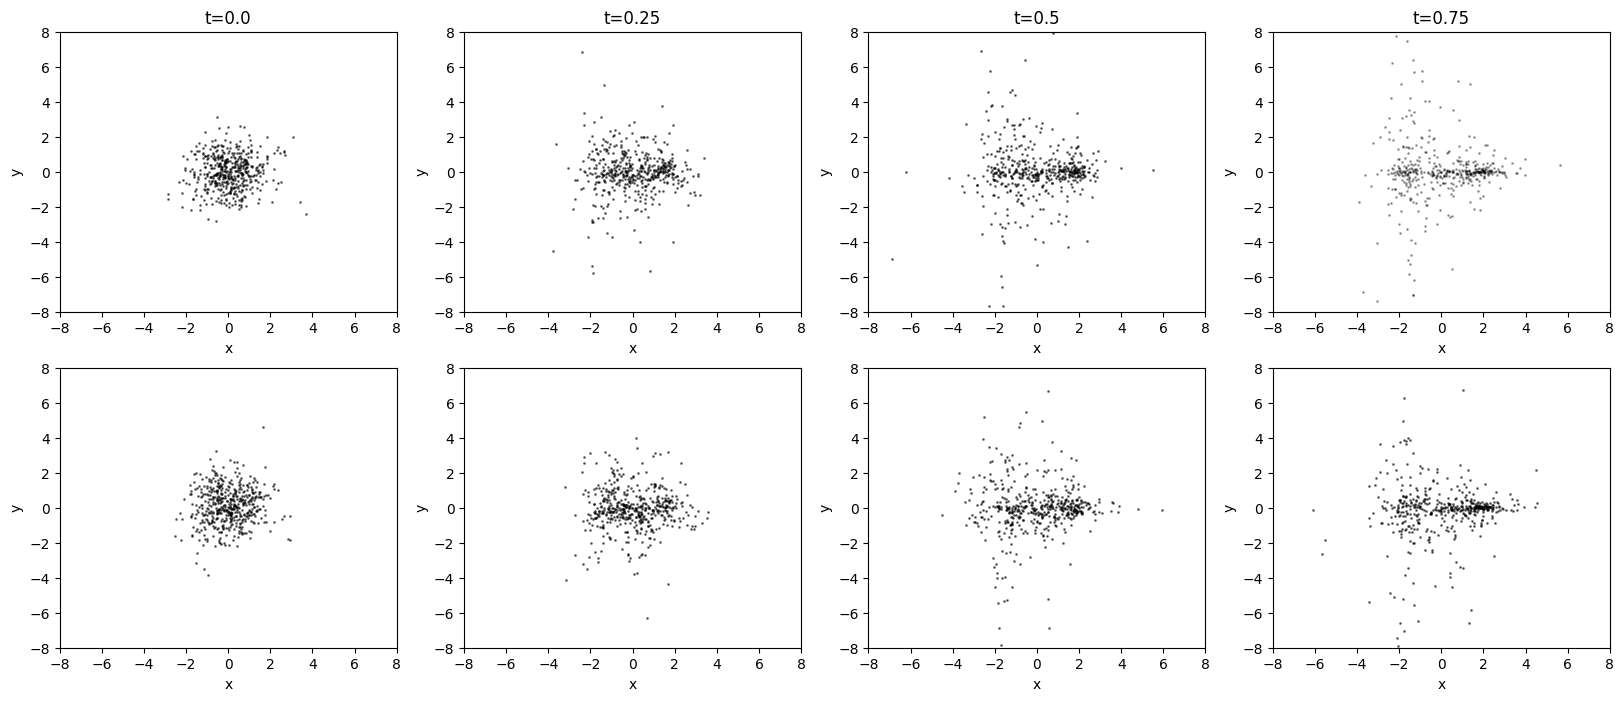

In [24]:
# Resampling
plt.figure(figsize=(20,8))
plt.subplot(2, 4, 1)
xxx = np.concatenate((position_x[0:1,:].T, position_y[0:1,:].T), axis=1)
plot_data(xxx, color="black", alpha=0.5)
plt.title("t=0.0")
plt.subplot(2, 4, 2)
xxx = np.concatenate((position_x[5:6,:].T, position_y[5:6,:].T), axis=1)
plot_data(xxx, color="black", alpha=0.5)
plt.title("t=0.25")
plt.subplot(2, 4, 3)
xxx = np.concatenate((position_x[10:11,:].T, position_y[10:11,:].T), axis=1)
plot_data(xxx, color="black", alpha=0.5)
plt.title("t=0.5")
plt.subplot(2, 4, 4)
xxx = np.concatenate((position_x[15:16,:].T, position_y[15:16,:].T), axis=1)
plot_data(xxx, color="black", alpha=0.3)
plt.title("t=0.75")
plt.subplot(2, 4, 5)
samples = model.sample(500, t=0).data
plot_data(samples, color="black", alpha=0.5)
# plt.title("t=0.0")
plt.subplot(2, 4, 6)
samples = model.sample(500, t=0.25).data
plot_data(samples, color="black", alpha=0.5)
# plt.title("t=0.25")
plt.subplot(2, 4, 7)
samples = model.sample(500, t=0.5).data
plot_data(samples, color="black", alpha=0.5)
# plt.title("t=0.5")
plt.subplot(2, 4, 8)
samples = model.sample(500, t=0.75).data
plot_data(samples, color="black", alpha=0.5)
# plt.title("t=0.75")
plt.show()